In [ ]:
# Unzip data
!tar zxvf './lens_find.tgz' -C './data/'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
import matplotlib.pyplot as plot
import csv
import pandas as pd
from astropy.io import fits

import sys
import random
import math
import os

In [ ]:
# Set random seed
SEED = 1
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
BASEPATH = './data/SpaceBasedTraining' # Location of data
MODELPATH = './weights' # Location of weights
BATCH_SIZE = 30
EPOCHS = 300
LEARNING_RATE = 1e-3

In [ ]:
def load_train_data():
  classifications = pd.read_csv(os.path.join('/content/SpaceBasedTraining', 'classifications.csv'))

  image_files = os.listdir(os.path.join(BASEPATH, 'Data.0', 'Public', 'Band1'))

  image_data = []
  labels = []

  for file in image_files:
      filename = os.path.join(BASEPATH, 'Data.0', 'Public', 'Band1', file)
      f = fits.open(filename)
      image = f[0].data
      image_data.append(image)
      f.close()
      image_id = int(file.replace('imageEUC_VIS-', '').replace('.fits', ''))
      csv_data = classifications[classifications['ID'] == image_id].values[0]
      labels.append(int(csv_data[1]))
      
  image_data = np.expand_dims(np.array(image_data), axis=-1) # Add channel axis
  labels = np.array(labels)

  np.save(os.path.join(BASEPATH, 'X.npy'), image_data)
  np.save(os.path.join(BASEPATH, 'Y.npy'), labels)

  return image_data, labels

In [ ]:
# Load train data
X_TRAIN, Y_TRAIN = load_train_data()

# Standardize data
X_TRAIN = ((X_TRAIN - np.mean(X_TRAIN, axis=(1, 2), keepdims=True))
          / np.std(X_TRAIN, axis=(1, 2), keepdims=True))

# Shuffle train data
perm = np.random.permutation(len(X_TRAIN))
X_TRAIN, Y_TRAIN = X_TRAIN[perm], Y_TRAIN[perm]

# Train / Val split
val_size = len(X_TRAIN) // 10
X_VAL, Y_VAL = X_TRAIN[:val_size], Y_TRAIN[:val_size]
X_TRAIN, Y_TRAIN = X_TRAIN[val_size:], Y_TRAIN[val_size:]

In [ ]:
def make_model(image_shape):
  image_inputs = keras.Input(shape=image_shape)
  x = keras.Sequential([layers.RandomFlip(),
                        layers.RandomRotation(0.5)
                        ])(image_inputs)
  
  x = layers.Conv2D(16, 4, activation='relu')(x)
  x = layers.Conv2D(16, 3, activation='relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.BatchNormalization()(x)

  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.MaxPool2D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(128, 3, activation='relu')(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Conv2D(128, 3, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Flatten()(x)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  outputs = layers.Dense(1, activation='sigmoid')(x)

  return keras.Model(image_inputs, outputs)

In [ ]:
class TrackBestPerformance(keras.callbacks.Callback):
  """
  Callback to keep track of model weights which give best val_auc
  After training completes, the model is assigned with the best model weights
  """
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.best_auc = 0
    self.best_epoch = -1
    self.best_weights = None
  
  def on_epoch_end(self, epoch, logs=None):
    current_auc = logs['val_auc']
    if current_auc >= self.best_auc:
      self.best_auc = current_auc
      self.best_epoch = epoch
      self.best_weights = self.model.get_weights()
    elif self.best_auc - current_auc <= 0.0001:
      self.best_epoch = epoch
      self.best_weights = self.model.get_weights()
  
  def on_train_end(self, logs=None):
    self.model.set_weights(self.best_weights)
    print(f'\nBest validation AUC is {self.best_auc} on epoch #{self.best_epoch + 1}')


In [ ]:
class RandomSampleGenerator(keras.utils.Sequence):
    """
    Generates batches containing equal number of positive and negative examples
    to rectify class imbalance in data
    """
    def __init__(self, x, y, batch_size, seed=None):
        self.x_positive = x[y == 1]
        self.y_positive = y[y == 1]

        self.x_negative = x[y == 0]
        self.y_negative = y[y == 0]

        self.epoch_length = len(x) // batch_size
        self.batch_size = batch_size
        self.seed = seed
        self.reset()

    def reset(self):
        self.rng = np.random.default_rng(self.seed)

    def __len__(self):
        return self.epoch_length

    def __getitem__(self, idx):  # Positive samples
        batch_positive_indices = self.rng.choice(self.x_positive.shape[0],
                                                 self.batch_size // 2,
                                                 replace=False)
        batch_x_positive = self.x_positive[batch_positive_indices]
        batch_y_positive = self.y_positive[batch_positive_indices]

        # Negative samples
        batch_negative_indices = self.rng.choice(self.x_negative.shape[0],
                                                 int(np.ceil(self.batch_size / 2)),
                                                 replace=False)
        batch_x_negative = self.x_negative[batch_negative_indices]
        batch_y_negative = self.y_negative[batch_negative_indices]

        # Concat both samples
        batch_x = np.concatenate((batch_x_positive, batch_x_negative))
        batch_y = np.concatenate((batch_y_positive, batch_y_negative))

        return batch_x, batch_y

data_generator = RandomSampleGenerator(X_TRAIN, Y_TRAIN,
                                       batch_size=BATCH_SIZE, seed=SEED)

In [ ]:
model = make_model(X_TRAIN.shape[1:])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=keras.metrics.AUC(name='auc'))

history = model.fit(data_generator, validation_data=(X_VAL, Y_VAL),
                    epochs=EPOCHS,
                    callbacks=[TrackBestPerformance()])

Epoch 1/300
270/270 [==============================] - 8s 20ms/step - loss: 0.7991 - auc: 0.6302 - val_loss: 0.8102 - val_auc: 0.6040
Epoch 2/300
270/270 [==============================] - 5s 18ms/step - loss: 0.6064 - auc: 0.7484 - val_loss: 0.8753 - val_auc: 0.7528
Epoch 3/300
270/270 [==============================] - 5s 18ms/step - loss: 0.5669 - auc: 0.7747 - val_loss: 1.0119 - val_auc: 0.7310
Epoch 4/300
270/270 [==============================] - 5s 18ms/step - loss: 0.5508 - auc: 0.7895 - val_loss: 0.5127 - val_auc: 0.8091
Epoch 5/300
270/270 [==============================] - 5s 18ms/step - loss: 0.5054 - auc: 0.8252 - val_loss: 1.1225 - val_auc: 0.7097
Epoch 6/300
270/270 [==============================] - 5s 18ms/step - loss: 0.4678 - auc: 0.8530 - val_loss: 0.5981 - val_auc: 0.8166
Epoch 7/300
270/270 [==============================] - 5s 19ms/step - loss: 0.4448 - auc: 0.8677 - val_loss: 0.7220 - val_auc: 0.8398
Epoch 8/300
270/270 [==============================] - 5s 18ms

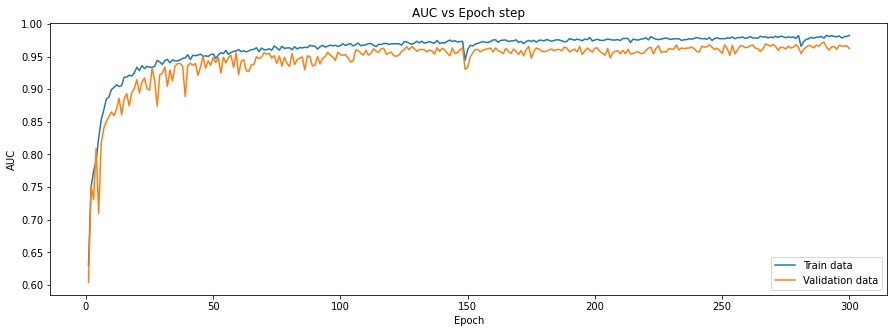

In [ ]:
_, axes = plot.subplots(figsize=(15, 5))
_ = axes.plot(range(1, EPOCHS + 1), history.history['auc'], label='Train data')
_ = axes.plot(range(1, EPOCHS + 1), history.history['val_auc'], label='Validation data')
_ = axes.set(xlabel='Epoch', ylabel='AUC', title='AUC vs Epoch step')
_ = plot.legend()

In [ ]:
print('Best validation AUC: {}'.format(max(history.history['val_auc'])))
print('Corresponding train AUC: {}'.format(history.history['auc'][np.argmax(history.history['val_auc'])]))

Best validation AUC: 0.9720777273178101
Corresponding train AUC: 0.9780259728431702


In [ ]:
X_BATCHES_TRAIN = np.array_split(X_TRAIN, 50, axis=0)
Y_PRED_TRAIN = np.concatenate([model(x_batch).numpy() for x_batch in X_BATCHES_TRAIN], axis=0)[:, 0]

X_BATCHES_VAL = np.array_split(X_VAL, 50, axis=0)
Y_PRED_VAL = np.concatenate([model(x_batch).numpy() for x_batch in X_BATCHES_VAL], axis=0)[:, 0]

In [ ]:
def compute_roc_points(y, y_pred, num_thresholds=200):
  thresholds = np.linspace(0., 1., num_thresholds)

  tp, fp, tn, fn = [], [], [], []

  for threshold in thresholds:
    y_pred_label = (y_pred > threshold).astype(int)
    tp.append(np.count_nonzero(((y_pred_label == 1) & (y == 1)), axis=0))
    fp.append(np.count_nonzero(((y_pred_label == 1) & (y == 0)), axis=0))
    tn.append(np.count_nonzero(((y_pred_label == 0) & (y == 0)), axis=0))
    fn.append(np.count_nonzero(((y_pred_label == 0) & (y == 1)), axis=0))

  tp, fp, tn, fn = np.array(tp), np.array(fp), np.array(tn), np.array(fn)

  tp_rate = tp / (tp + fn)
  fp_rate = fp / (fp + tn)

  return fp_rate, tp_rate

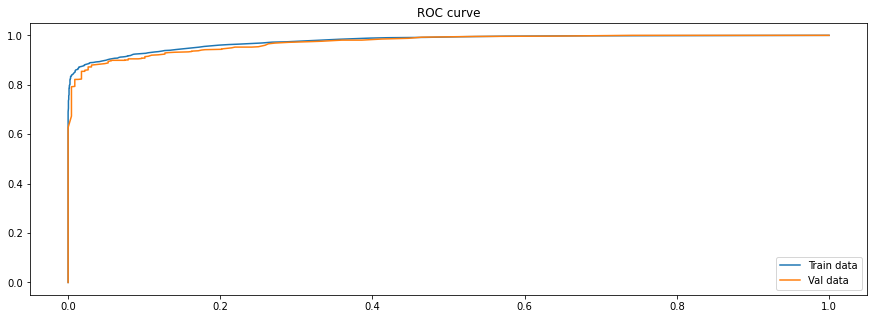

In [ ]:
fig, axes = plot.subplots(figsize=(15, 5))

# ROC curve on train data
fp_rate_train, tp_rate_train = compute_roc_points(Y_TRAIN, Y_PRED_TRAIN)
_ = axes.plot(fp_rate_train, tp_rate_train, label='Train data')

# ROC curve on validation data
fp_rate_val, tp_rate_val = compute_roc_points(Y_VAL, Y_PRED_VAL)
_ = axes.plot(fp_rate_val, tp_rate_val, label='Val data')

_ = axes.set(title='ROC curve')
_ = plot.legend()

In [ ]:
# Save model weights
model.save(MODELPATH)

INFO:tensorflow:Assets written to: /content/weights/assets


In [ ]:
# Compress model weights
!zip -r './test_2_weights.zip' './weights'

  adding: content/weights/ (stored 0%)
  adding: content/weights/variables/ (stored 0%)
  adding: content/weights/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/weights/variables/variables.index (deflated 74%)
  adding: content/weights/assets/ (stored 0%)
  adding: content/weights/keras_metadata.pb (deflated 94%)
  adding: content/weights/saved_model.pb (deflated 89%)


In [ ]:
# Load model weights
model = keras.models.load_model(MODELPATH)

In [ ]:
_ = model.evaluate(X_VAL, Y_VAL)

29/29 [==============================] - 0s 5ms/step - loss: 0.2694 - auc: 0.9721


In [ ]:
# Run this cell to evaluate on test data
X_TEST, Y_TEST = None, None # load test data here. Shape: (None, 101, 101, 1)

# Standardize test data
X_TEST = ((X_TEST - np.mean(X_TEST, axis=(1, 2), keepdims=True))
          / np.std(X_TEST, axis=(1, 2), keepdims=True))

model.evaluate(X_TEST, Y_TEST)